Title: Introduction to the Frequency Domain
Author: Thomas Breuel
Institution: UniKL

Introduction to the Frequency Domain
====================================

In [1]:

from scipy.ndimage import filters
def imrow(*args,**kw):
    gray()
    size = kw.get("s",6)
    if "s" in kw: del kw["s"]
    n = len(args)
    subplots(1,n,figsize=(n*size,size))
    for i,im in enumerate(args):
        subplot(1,n,i+1); imshow(im,interpolation='nearest',**kw)
def roll2(image,dx,dy):
    return roll(roll(image,dx,axis=0),dy,axis=1)

Periodic Boundary Conditions
----------------------------

Fourier transforms use periodic boundary conditions (we had talked about this before).
So, in order to make our signal looks nice and periodic,
we modify the image so that it goes smoothly towards zero around the edges of the image.
In practice, we don't need to do something as drastic as this,
but in the example, the intermediate results look nicer.

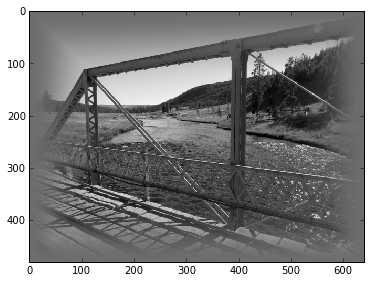

In [2]:
image = mean(imread("bridge.jpg"),axis=2)
image = image-mean(image)
w,h = image.shape
ys,xs = meshgrid(range(-h//2,h-h//2),range(-w//2,w-w//2))
r = minimum(h//2-abs(ys),w//2-abs(xs))
r = 1.0-exp(-r**2/80.0**2)
image = r*image
imrow(image)

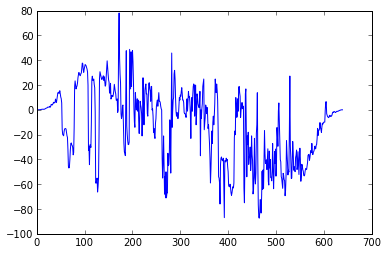

In [3]:
plot(image[200,:])

Fourier Transforms and the Frequency Domain
------------------

The Fourier transform is a linear, invertible transformation of the image
that yields a complex result.
The Fourier transform for images is implemented by the `fft2` function,
and its inverse by the `ifft2` function.

In principle, `ifft2(fft2(image))` should be the identity function,
but `ifft2` returns complex numbers; the imaginary part is nearly zero (roundoff error),
so we are just interested in the real part.

Note that the Fourier transformation is _not shift invariant_.

6.03959719156e-13


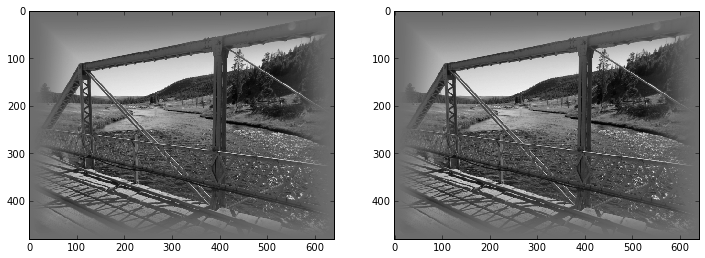

In [4]:
f = fft2(image)
imrow(image,real(ifft2(f)))
print amax(abs(imag(ifft2(f))))

What is this mysterious Fourier transform `f`?

We can't really easily tell, because it is complex.
However, the magnitude is kind of instructive.
Since the magnitude spans a very large range,
we compress the range with a $\gamma=0.2$.

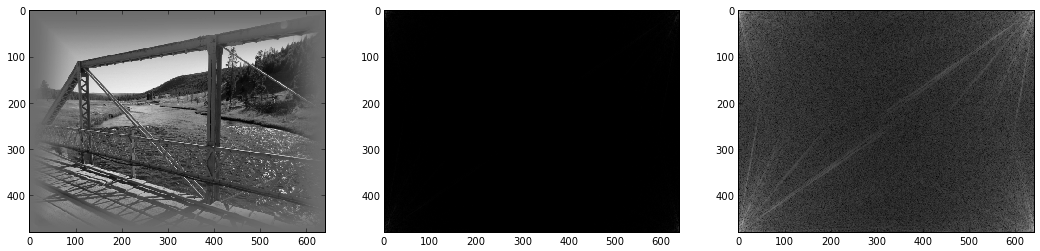

In [5]:
imrow(image,abs(f),abs(f)**0.2)

Let's try some simple test images.  The most obvious one is the impulse.

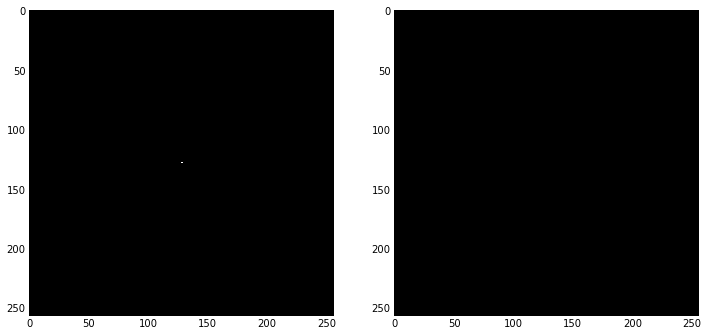

In [6]:
impulse = zeros((256,256))
impulse[128,128] = 1.0
spectrum = abs(fft2(impulse))**0.2
imrow(impulse,spectrum)

Didn't that work?  Actually, it did, but the output is constant.

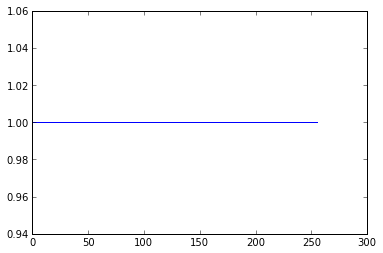

In [7]:
plot(spectrum[10,:])

It's only the magnitude of the output that's constant.  The real part jumps back between -1 and 1.

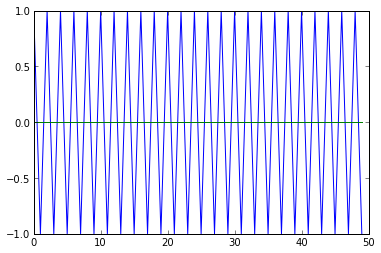

In [8]:
f = fft2(impulse)[50,50:100]
plot(f.real)
plot(f.imag)

Maybe something slightly bigger than an impulse gives us a better idea.

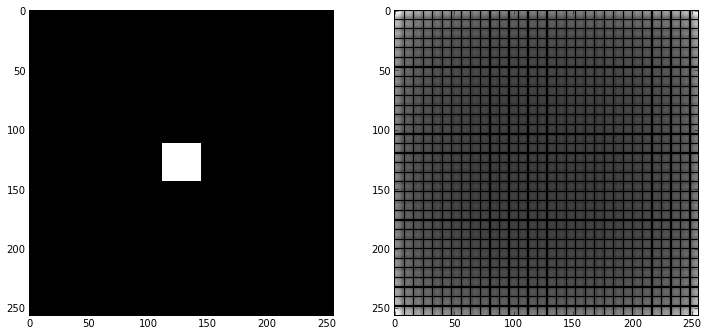

In [9]:
step = zeros((256,256))
step[112:144,112:144] = 1.0
spectrum = abs(fft2(step))**0.2
imrow(step,spectrum)

That's still pretty mysterious. 

Actually, it turns out that the signal with the simplest 2D Fourier transform is a sine wave.
This will become clearer when we look at this again in processing of sound signals later.

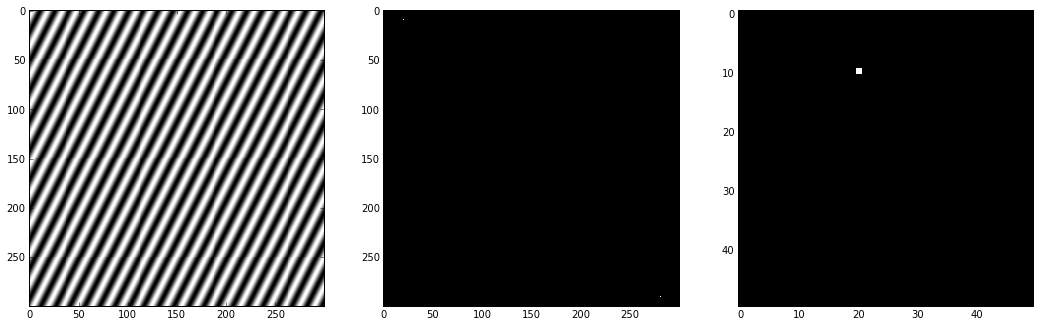

In [10]:
ys,xs = meshgrid(range(300),range(300))
wave = sin((xs+2.0*ys)*pi/15.0)
spectrum = abs(fft2(wave))**0.2
imrow(wave,spectrum,spectrum[:50,:50])

Notice that there is just a single pixel at (10,20).  Why is it there?  Roughly speaking, because there are 30 repeats in the y direction, and 60 repeats in the x direction.

We can now mix multiple of these signals and the Fourier transform will resolve these components for us.

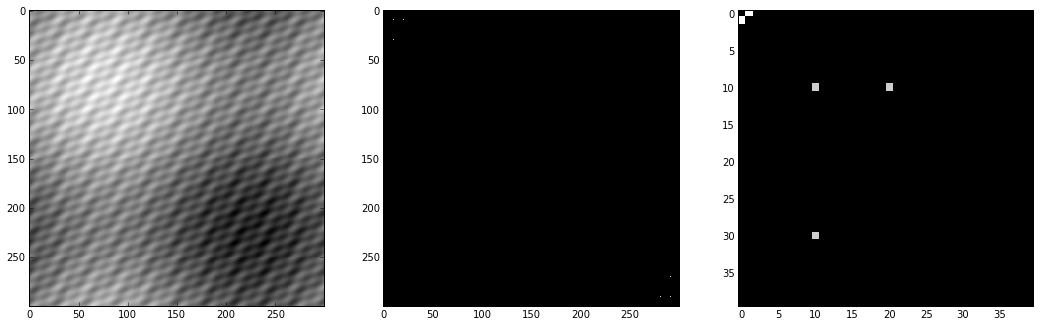

In [11]:
wave = sin((xs+2.0*ys)*pi/15.0)+cos((3.0*xs+ys)*pi/15.0)+sin((xs+ys)*pi/15.0)+3.0*sin(xs*pi/150.0)+3.0*sin(ys*pi/150.0)
spectrum = abs(fft2(wave))**0.2
imrow(wave,spectrum,spectrum[:40,:40])

Fourier transforms model images as being composed of sine waves that are shifted and added.

This turns out not to be a very good statistical model of real-world images.
It is, however, a good model for audio and radio signals, which is where most
of the theory comes from.  And the theory works even if the images are
not naturally represented using the basis functions of the filters.

Frequency Domain Filtering
-------------------------

The basic idea behind frequency domain filtering is to perform a Fourier transform,
select a subset of the frequencies--those we are interested in--and then transform back.

Now, the low frequencies happen to be in the corners of the Fourier transform (this
is just a convention).  

So, we take the original Fourier transform and just copy values from its corners,
then transform back.  And let's also transform back everything but the values we selected.

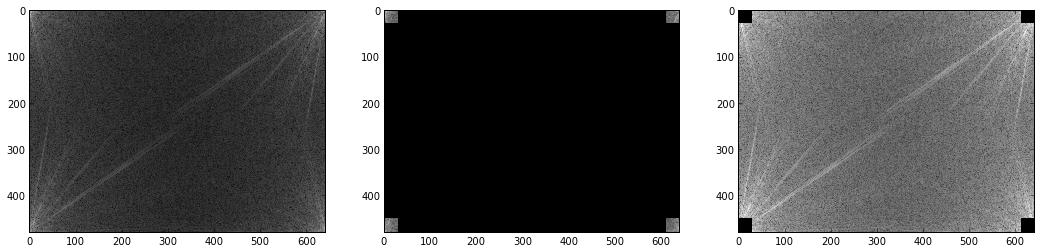

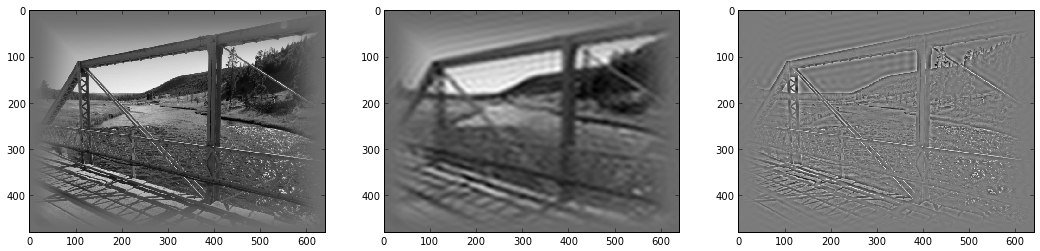

In [12]:
f = fft2(image)
f2 = zeros(f.shape,dtype=complex)
d = 30
f2[:d,:d] = f[:d,:d]
f2[:d,-d:] = f[:d,-d:]
f2[-d:,:d] = f[-d:,:d]
f2[-d:,-d:] = f[-d:,-d:]
imrow(abs(f)**0.2,abs(f2)**0.2,abs(f-f2)**0.2)
imrow(image,real(ifft2(f2)),real(ifft2(f-f2)))

What we can see here is that if we just select low frequencies (a *low pass filter*),
we get a filter that looks like a smoothing filter.

If we just select high frequencies (a *high pass filter*,
we get a filter that looks like a derivative filter.

However, there is a lot of *ringing* in these images,
the little wavy black lines surrounding edges in the filtered images.
Strict low-pass or high-pass filters show this effect.

# Filters in the Frequency Domain

(Convolution vs Fourier Transform)

The Fourier transform is a very special kind of filter,
because it transforms convolutions into multiplications.

Let's write ${\cal F}[s]$ for the Fourier transform of
the signal $s$.  Then,

${\cal F}[s * t] = {\cal F}[s] \cdot {\cal F}[t]$

or

$s * t = {\cal F}^{-1}[{\cal F}[s] \cdot {\cal F}[t]]$



(Speedup from FFT)

This matters a great deal because using the *fast Fourier transform* algorithm (*FFT*),
we can compute the Fourier transform of a signal with $N$ elements in time $N \log N$.

So, a naive implementation of convolution of two sequences of length $N$ takes time $O(N^2)$,
while a convolution implemented with Fourier transforms takes time $O(N \log N)$.
Radios, disk drive, cell phones, and many other modern devices take advantage of this.

Let us explore this issue computationally a bit more by looking at the Gaussian filter
in the image domain and the frequency domain.




In [13]:
def impulse(w,h):
    image = zeros((w,h))
    image[w//2,h//2] = 1.0
    return image

Let's compute the impulse response of the Gaussian filter.

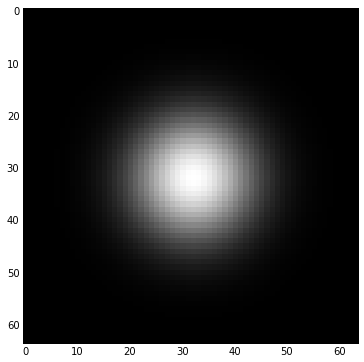

In [14]:
from scipy.ndimage import filters
gaussian = filters.gaussian_filter(impulse(64,64),8.0)
imrow(gaussian)

We can convolve with that directly to obtain the following image.

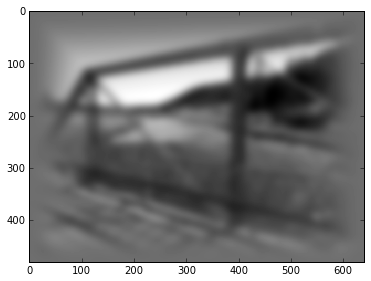

In [15]:
result1 = filters.convolve(image,gaussian)
imrow(result1)

Alternatively, we can multiply with the Fourier transform of the impulse response.

(We recompute the Fourier transform because the `fft2` function wants the impulse
response centered on (0,0), while the `convolve` function wants it centerd on `(w//2,h//2)`.
Furthermore, `fft2` requires an impulse response padded with zeros to the size of the image.)

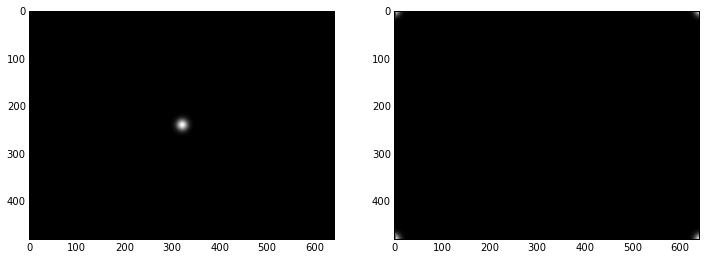

In [16]:
gaussian0 = filters.gaussian_filter(impulse(*image.shape),8.0)
gaussian = roll2(gaussian0.copy(),w//2,h//2)
imrow(gaussian0,gaussian)

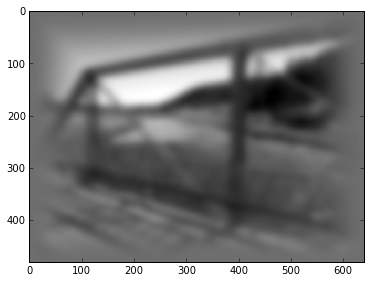

In [17]:
result2 = real(ifft2(fft2(image)*fft2(gaussian)))
imrow(result2)

These two are the same.

Since we're going to look at more spectra (magnitudes of Fourier transforms), let's
define a function that makes this more convenient.
This function also shifts the low frequencies to the center of the image, where
they are easier to see.

In [18]:
def spectrum(image,mode=lambda x:x**0.2,eps=1e-6):
    w,h = image.shape
    return roll2(mode(maximum(eps,abs(fft2(image)))),w//2,h//2)

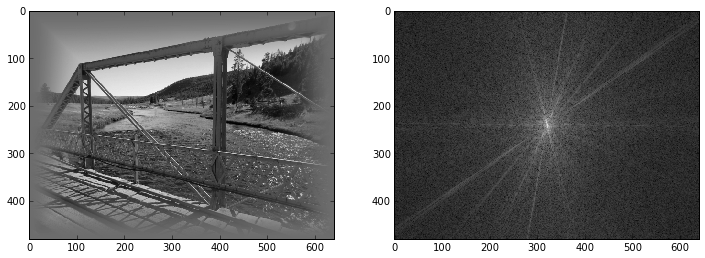

In [19]:
imrow(image,spectrum(image))

So, the spectrum of the original image has a lot of high frequency components.
These are organized in "spikes", and these are actually perpendicular to the
largest edges found in the image.

Let's look at the filtered outputs.

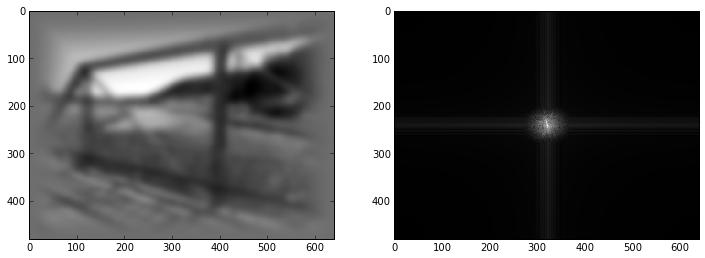

In [20]:
imrow(result1,spectrum(result1))

The above filter was implemented by the `convolve` function.
It got rid of most of the high frequency components, although there are
smallish streaks still visible.

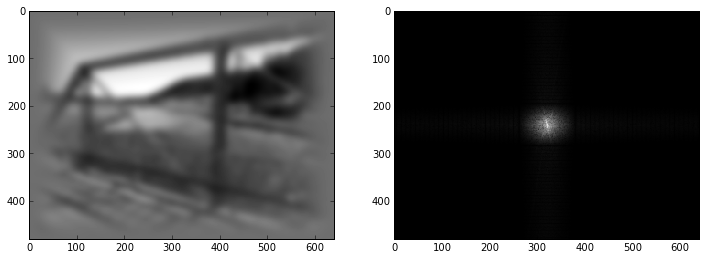

In [21]:
imrow(result2,spectrum(result2))

That filter was implemented by Fourier transform.  The image looks the same, but it really
got rid of all high frequency components.  This difference is actually very slight and
probably related to the tructation in the `convolve` function.  It is only visible because
we are using $\gamma=0.2$ for display.

Now, we multiply the image with the Fourier transform of the Gaussian.
What does that look like?

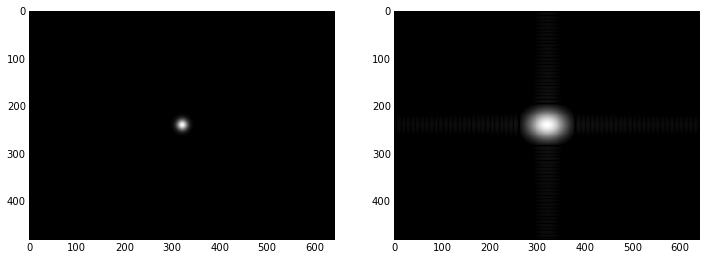

In [22]:
imrow(roll2(gaussian,w//2,h//2),spectrum(gaussian))

The smooth falloff of the Gaussian is really important. 
Let's construct a lowpass filter of exactly the same size as the Gaussian and compare the two.

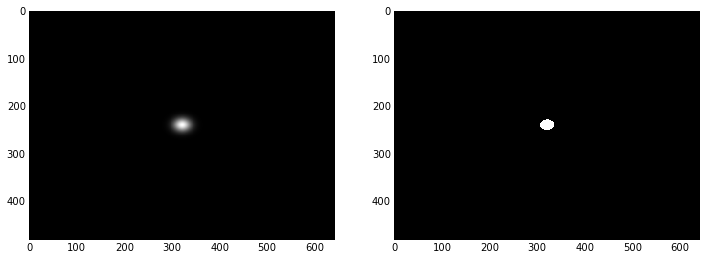

In [23]:
f = fft2(gaussian)
mag = abs(f)
lowpass = where(mag>0.5,f/mag,0.0)
imrow(roll2(abs(f),w//2,h//2),roll2(abs(lowpass),w//2,h//2))

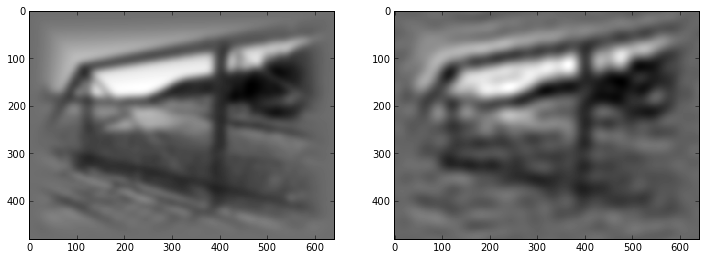

In [24]:
imrow(real(ifft2(fft2(image)*f)),real(ifft2(fft2(image)*lowpass)))

As we can see above, the Gaussian-filtered image looks smoothly blurred,
while the lowpass filtered image has roughly the same amount of blur,
but lots of additional "structure" due to ringing.